### Import des différents librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold

#The model
from sklearn.ensemble import IsolationForest

#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings 
warnings.simplefilter("ignore")

### Pretraitement

In [2]:
class AnomalyDetectionDataLoader:
    
    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        
        self.data.drop_duplicates(keep="last", inplace=True)

        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def preprocess_data(self):

        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler



### Transformation des targets
ypred return un vecteur contenant que de -1 pour des données anormales et 1 pour les données normales alors que les targets des <br>
des données initial contiennet des 0 pour des données normales et 1 pour des données anormales. Il faut donc transformer ce vecteur <br>
en un vecteur contenant des 1 pour des données normales et -1 pour les anomalies

In [3]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

### Visualisation des résultats

In [4]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

### Recherche des hyperparametres :Grid Search Cross-Validation (GridSearchCV)
Notre approche ici es d'implémenter notre propre fonction pour la recherche des hyper paramètres de nos différents modèles.<br> Par exemple les étiquettes de prédiction de notre jeu de données de fraudes banquaires sont 0 pour les transactions normales et 1 pour les transaction frauduleuses.<br> Cependant les étiquettes prédites par l'algorithme de forêt d'isolation (Isoalation Forest) sont -1 et 1. Les étiquettes prédictes et les étiquettes réelles sont différentes. <br>
Pour faire face à ce problème nous avons implémenté deux fonctions, transformed_target et inverse_transforme_target, pour convertir les labels de sorte à avoir les deux labels dans la bonne version. <br>
Cependant lors de la recherche des hyeper paramètres, nous passont nos données une seule fois en argment de la fonction GridSearchCV. Nous ne sommes donc pas à mesure de convertir les labels de prédiction de chaques modèle afin de l'evaluer. Nous avons jugé interessant d'implémenter notre fonction de GridSearchCV de sorte à pouvoir transformer les étiquettes de prédictions de chaque modèle sur un lot de paramètres données afin de pouvoir l'évaluer. 

In [5]:
class CustomGridSearchCV:
    
    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):
        
        f1_scorer = make_scorer(f1_score)
        param_grid = ParameterGrid(self.param_grid)
        skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)
        
        for params in tqdm(param_grid):
            
            
            total_score = 0

            # Itérer sur les plis de la validation croisée
            for train_index, val_index in tqdm(skf.split(X,y)):
                xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
                ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

                # Entraîner le modèle
                model = self.estimator.set_params(**params)
                model.fit(xtrain_fold)

                # Faire des prédictions
                ypred_val = model.predict(xval_fold)
                ypred_val = inverse_transform_target(ypred_val)

                current_score = f1_score(ypred_val, yval_fold)

                total_score += current_score

            avg_score = total_score / self.n_splits

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,xtest):
        return self.best_estimator.predict(xtest)

## Expérimentation sur différents jeux de données

### Credit cards fraud detection
Le jeu de données des transaction frauduleuses

In [6]:
# Utilisation de la classe
data_loader = AnomalyDetectionDataLoader(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv")
data_loader.load_data()
data_loader.preprocess_data()
data_loader.split_data()

xtrain, ytrain = data_loader.get_train_data()
xtest, ytest = data_loader.get_test_data()
scaler = data_loader.get_scaler()


In [683]:
parameters={
    "n_estimators":[100,200,300,400,500],
    "contamination":[0.15],
    "max_samples":[1.0],
    "max_features":[1.0],
    # "bootstrap":[False,True]
}

best_par={
          'contamination': [0.009],
          'max_features': [0.9], 
          'max_samples': [0.8], 
          'n_estimators': [300,400,500,600,700,800,900,1000]
}
model=CustomGridSearchCV(estimator=IsolationForest(random_state=42), param_grid=best_par, n_splits=5, random_state=42)
model.fit(xtrain,ytrain)

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.2167861213355536
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 400}
Score moyen (f1_score): 0.21764028469782656
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.2188208620180001
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 600}
Score moyen (f1_score): 0.21925998325015073
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.218392112496474
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 800}
Score moyen (f1_score): 0.21789017424105106
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 900}
Score moyen (f1_score): 0.21695708750343154
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 1000}
Score moyen (f1_score): 0.21664638063250502
 
Meilleurs paramètres : {'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 600}
Meilleur score moyen (f1_score) : 0.21925998325015073


In [8]:
params_iforest={'contamination': 0.009, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 600}
iforest=IsolationForest(**params_iforest)
iforest.fit(xtrain)

IsolationForest(contamination=0.009, max_features=0.9, max_samples=0.8,
                n_estimators=600)

In [10]:
ypred=iforest.predict(xtest)

In [11]:
ypred=inverse_transform_target(ypred)

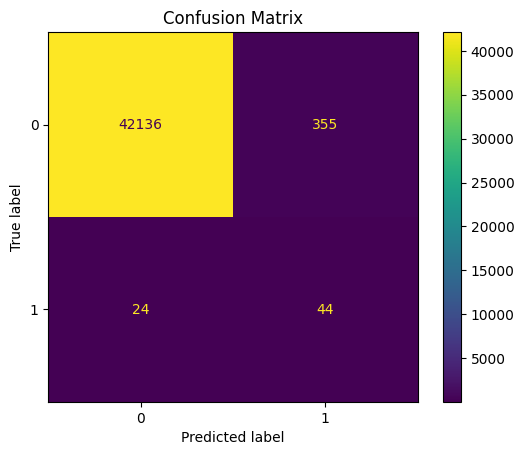

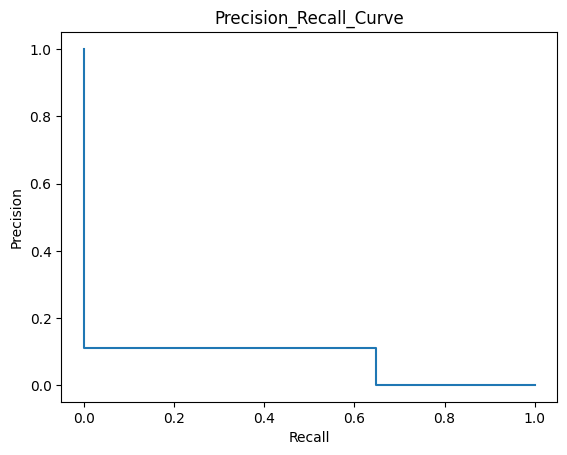

roc_auc 0.8193520565600743


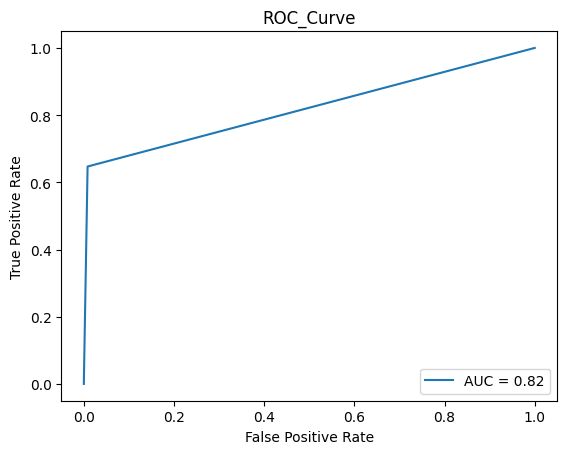

   f1_score  accuracy_score  precision_score  recall_score
0  0.188437        0.991095         0.110276      0.647059


In [12]:
evaluation(ytest,ypred)